# Dual Moons likelihood

Dual moons is a tricky likelihood that mimics physically challenging models.

In [1]:

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"
from jax.config import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO[2023-04-16 00:02:37,904]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-04-16 00:02:37,905]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-04-16 00:02:37,905]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-04-16 00:02:37,908]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-04-16 00:02:37,909]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-04-16 00:02:37,909]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
from jax._src.scipy.special import logsumexp


def log_likelihood(x):
    """
    Dual moon log-likelihood.
    """

    def fasym(t):
        return jnp.piecewise(
            t, [t < 0, t >= 0],
            [lambda x: (x / 2) ** 2,
             lambda x: (x / 0.5) ** 4
             ])

    xx = x[..., :1]
    xy = x[..., 1:2]
    rho1 = jnp.sqrt((xx) ** 2 + (xy) ** 2)
    theta1 = jnp.arctan2(xy, xx)
    term1 = ((rho1 - 2) / 0.05) ** 2
    term2 = fasym(theta1 - jnp.pi / 2) / 0.2

    rho2 = jnp.sqrt((xx) ** 2 + (xy) ** 2)
    theta2 = jnp.arctan2(xy, xx)
    term12 = ((rho2 - 2) / 0.05) ** 2
    term22 = fasym(theta1 + jnp.pi / 3) / 0.2

    pe = logsumexp(-jnp.stack([term1 + term2, term12 + term22]), axis=0)

    return pe.squeeze()


def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=-4 * jnp.ones(2), high=4. * jnp.ones(2)), name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=-5.104862238439268


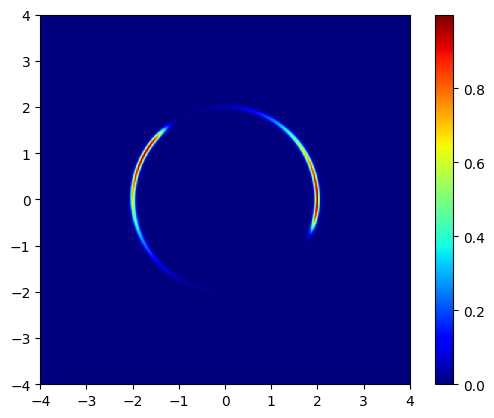

In [3]:

u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(jnp.exp(lik), origin='lower', extent=(-4, 4, -4, 4), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=200, num_parallel_samplers=6,
                                   max_samples=1e4)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)


WARNING[2023-04-16 00:02:39,306]: Increasing num_live_points (200) by 4 to closest multiple of num_parallel_samplers.
WARNING[2023-04-16 00:02:39,307]: Increasing max_samples (10000.0) by 2 to closest multiple of num_parallel_samplers.
WARNING[2023-04-16 00:02:39,308]: Increasing num_live_points (200) by 4 to closest multiple of num_parallel_samplers.
WARNING[2023-04-16 00:02:39,309]: Increasing max_samples (10000.0) by 2 to closest multiple of num_parallel_samplers.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/site-packages/jax/_src/dispatch.py:400: UserWarning: The jitted function fresh_run includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/sit

In [5]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 131633
# samples: 2102
# slices: 18564.0
# slices / acceptance: 13.0
# likelihood evals / sample: 62.6
# likelihood evals / slice: 7.0
--------
logZ=-5.17 +- 0.15
H=5.7
ESS=425
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 0.53 +- 0.8 | -0.54 / 0.57 / 1.55 | 1.0 | 1.0
x[1]: -0.2 +- 1.7 | -2.0 / -1.4 / 2.0 | -1.7 | -1.7
--------


WARNING[2023-04-16 00:02:50,161]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


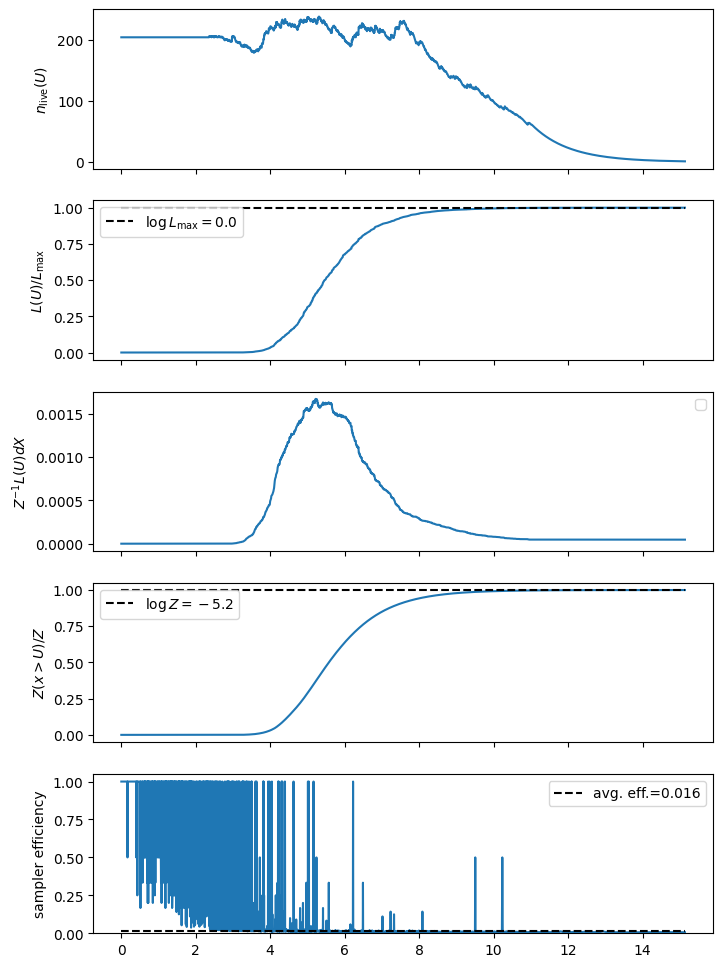

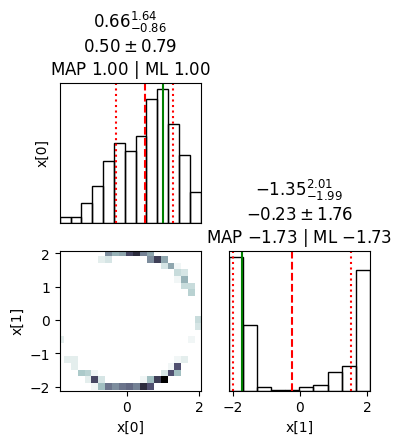

In [6]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)